# Определение и установка зависимостей

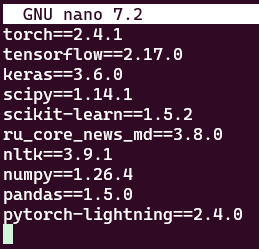

In [ ]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import torch
import pandas as pd
import numpy as np
import random
import re
import nltk
import spacy
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

# python -m spacy download ru_core_news_md

[nltk_data] Downloading package stopwords to /home/dmitry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dmitry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
torch.__version__

'2.4.1+cu121'

# Видеокарта

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Ваш девайс: {}".format(DEVICE))

Ваш девайс: cuda


In [ ]:
!nvidia-smi

Mon Oct 14 14:51:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P8             20W /  200W |     951MiB /   8192MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Установка seed-ов

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Загрузка датасета

In [ ]:
!gdown "https://drive.google.com/uc?id=1oU4WZnxmOwp2isH6Sv9yAk2C_48EJQhh" -O dataset.csv

Downloading...
From: https://drive.google.com/uc?id=1oU4WZnxmOwp2isH6Sv9yAk2C_48EJQhh
To: /home/dmitry/rl/study/dataset.csv
100%|██████████████████████████████████████| 13.3M/13.3M [00:00<00:00, 20.8MB/s]


# Обработка данных

In [ ]:
dataset = pd.read_csv("dataset.csv")
dataset.shape

(59889, 3)

In [ ]:
dataset.head()

,id,public_petition_text,reason_category
0,3168490,снег на дороге,Благоустройство
1,3219678,очистить кабельный киоск от рекламы,Благоустройство
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,3336285,Граффити,Благоустройство


In [ ]:
dataset["reason_category"].nunique() # Количество уникальных категорий

15

In [ ]:
dataset["reason_category"].unique() # Уникальные категории

array(['Благоустройство', 'Содержание МКД',
       'Незаконная информационная и (или) рекламная конструкция', 'Фасад',
       'Водоснабжение', 'Нарушение правил пользования общим имуществом',
       'Повреждения или неисправность элементов уличной инфраструктуры',
       'Кровля', 'Состояние рекламных или информационных конструкций',
       'Нарушение порядка пользования общим имуществом', 'Подвалы',
       'Водоотведение', 'Санитарное состояние', 'Центральное отопление',
       'Незаконная реализация товаров с торгового оборудования (прилавок, ящик, с земли)'],
      dtype=object)

In [ ]:
dataset["reason_category"].value_counts()

Благоустройство                                                                     34769
Содержание МКД                                                                      14461
Нарушение правил пользования общим имуществом                                        2170
Незаконная информационная и (или) рекламная конструкция                              1831
Фасад                                                                                1483
Повреждения или неисправность элементов уличной инфраструктуры                       1164
Кровля                                                                                825
Водоснабжение                                                                         809
Состояние рекламных или информационных конструкций                                    673
Санитарное состояние                                                                  434
Центральное отопление                                                                 284
Подвалы   

In [ ]:
# Отделение данных и целевой переменной
X = dataset["public_petition_text"].map(lambda x: x.lower()).values
y = dataset["reason_category"].map(lambda x: x.lower())

In [ ]:
id2label: dict = {index: label for index, label in enumerate(y.unique())}
label2id: dict = {label: index for index, label in id2label.items()}

# Предварительная обработка каждого объекта

In [ ]:
NLP = spacy.load('ru_core_news_md')
STOP_WORDS: set = set(stopwords.words("russian"))

In [ ]:
cleaned_petitions = [
    [re.sub(r'[^а-яА-Я\s]', '', word) for word in text.split()]
    for text in X
]

cleaned_petitions = [[word for word in text if word != ""] for text in cleaned_petitions]

text_tokens = [
    [word.lemma_ for word in NLP(" ".join(text)) if word.lemma_ not in STOP_WORDS]
    for text in cleaned_petitions
]

In [ ]:
print("Исходный текст:\n{0}\n\nПолученный список:\n{1}".format(X[1], text_tokens[1]))

Исходный текст:
очистить кабельный киоск от рекламы

Полученный список:
['очистить', 'кабельный', 'киоск', 'реклама']


# Векторизация

https://neptune.ai/blog/vectorization-techniques-in-nlp-guide

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [ ]:
MAX_NUM_WORDS: int = 1000 # максимальное количество уникальных слов
MAX_SEQUENCE_LENGTH: int = 20 # максимальную длина последовательности

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(text_tokens)
sequences = tokenizer.texts_to_sequences(text_tokens)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Формирование выборок

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
TEST_SPLIT: float = 0.2

In [ ]:
y = y.map(label2id).values

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    data,
    y,
    test_size=TEST_SPLIT,
    random_state=seed,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=TEST_SPLIT,
    random_state=seed,
)

In [ ]:
print("Размеры выборок:")
print("Обучающая выборка:", X_train.shape, y_train.shape)
print("Валидационная выборка:", X_val.shape, y_val.shape)
print("Тестовая выборка:", X_test.shape, y_test.shape)

Размеры выборок:
Обучающая выборка: (47911, 20) (47911,)
Валидационная выборка: (9582, 20) (9582,)
Тестовая выборка: (2396, 20) (2396,)


# Создание Tensor датасетов

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
BATCH_SIZE: int = 32
NUM_WORKERS: int = 11

In [ ]:
X_train_tensor = torch.IntTensor(X_train)
y_train_tensor = torch.IntTensor(y_train)
X_val_tensor = torch.IntTensor(X_val)
y_val_tensor = torch.IntTensor(y_val)
X_test_tensor = torch.IntTensor(X_test)
y_test_tensor = torch.IntTensor(y_test)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=11,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_WORKERS,
)


In [ ]:
sample = next(iter(train_dataloader))
print(sample[0][0], sample[1][0])

tensor([  0,   0,   0,   0,   0,   0,  21,  62,  36, 150, 171,  12,  69,  45,
          8, 134,  81, 108,  56,  91]) tensor(0)


# Создание моделей

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
NUM_EPOCHS = 10
HIDDEN_DIM = 128
NUM_CLASSES = len(id2label)
EMBEDDING_DIM = 200
VOCAB_SIZE = len(tokenizer.word_index) + 1

## RNN

In [ ]:
class RNNModel(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

        self.init_weights()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)

        acc = self.calculate_accuracy(y_hat, y)
        self.log("train_accuracy", acc)

        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss)

        acc = self.calculate_accuracy(y_hat, y)
        self.log("val_accuracy", acc)

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("test_loss", loss)

        acc = self.calculate_accuracy(y_hat, y)
        self.log("test_accuracy", acc)

    def init_weights(self):
        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
            if "bias" in name:
                nn.init.zeros_(param)

    def calculate_accuracy(self, y_hat, y):
        preds = torch.argmax(y_hat, dim=1)
        correct = (preds == y).sum().item()
        acc = correct / y.size(0)
        return acc

In [ ]:
rnn_model = RNNModel(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES
).to(DEVICE)

In [ ]:
rnn_trainer = Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator="gpu"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
rnn_trainer.fit(rnn_model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | embedding | Embedding | 5.0 M  | train
1 | rnn       | RNN       | 42.2 K | train
2 | fc        | Linear    | 1.9 K  | train
------------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.222    Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
rnn_trainer.validate(rnn_model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                     | 0/? [00:00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.9093091487884521     │
│         val_loss          │    0.34252065420150757    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.34252065420150757, 'val_accuracy': 0.9093091487884521}]

In [ ]:
rnn_trainer.test(rnn_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9015024900436401     │
│         test_loss         │    0.3781214654445648     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3781214654445648, 'test_accuracy': 0.9015024900436401}]

## LSTM

In [ ]:
class LSTMModel(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

        self.init_weights()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)

        acc = self.calculate_accuracy(y_hat, y)
        self.log("train_accuracy", acc)

        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss)

        acc = self.calculate_accuracy(y_hat, y)
        self.log("val_accuracy", acc)

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("test_loss", loss)

        acc = self.calculate_accuracy(y_hat, y)
        self.log("test_accuracy", acc)

    def init_weights(self):
        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
            if "bias" in name:
                nn.init.zeros_(param)

    def calculate_accuracy(self, y_hat, y):
        preds = torch.argmax(y_hat, dim=1)
        correct = (preds == y).sum().item()
        acc = correct / y.size(0)
        return acc

In [ ]:
lstm_model = LSTMModel(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES
).to(DEVICE)

In [ ]:
lstm_trainer = Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator="gpu"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
lstm_trainer.fit(lstm_model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | embedding | Embedding | 5.0 M  | train
1 | lstm      | LSTM      | 168 K  | train
2 | fc        | Linear    | 1.9 K  | train
------------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.729    Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
lstm_trainer.validate(lstm_model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                     | 0/? [00:00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.9223544001579285     │
│         val_loss          │     0.298117995262146     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.298117995262146, 'val_accuracy': 0.9223544001579285}]

In [ ]:
lstm_trainer.test(lstm_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9123539328575134     │
│         test_loss         │    0.33435702323913574    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.33435702323913574, 'test_accuracy': 0.9123539328575134}]

## GRU

In [ ]:
class GRUModel(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

        self.init_weights()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)

        acc = self.calculate_accuracy(y_hat, y)
        self.log("train_accuracy", acc)

        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss)

        acc = self.calculate_accuracy(y_hat, y)
        self.log("val_accuracy", acc)

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("test_loss", loss)

        acc = self.calculate_accuracy(y_hat, y)
        self.log("test_accuracy", acc)

    def init_weights(self):
        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
            if "bias" in name:
                nn.init.zeros_(param)

    def calculate_accuracy(self, y_hat, y):
        preds = torch.argmax(y_hat, dim=1)
        correct = (preds == y).sum().item()
        acc = correct / y.size(0)
        return acc

In [ ]:
gru_model = GRUModel(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES
).to(DEVICE)

In [ ]:
gru_trainer = Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator="gpu"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
gru_trainer.fit(gru_model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | embedding | Embedding | 5.0 M  | train
1 | gru       | GRU       | 126 K  | train
2 | fc        | Linear    | 1.9 K  | train
------------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.560    Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
gru_trainer.validate(gru_model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                     | 0/? [00:00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.9180755615234375     │
│         val_loss          │    0.3141489028930664     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.3141489028930664, 'val_accuracy': 0.9180755615234375}]

In [ ]:
gru_trainer.test(gru_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9077629446983337     │
│         test_loss         │    0.37991973757743835    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.37991973757743835, 'test_accuracy': 0.9077629446983337}]

# Метрики

In [ ]:
from sklearn.metrics import classification_report

## RNN

In [ ]:
y_pred = rnn_model(X_test_tensor).cpu().detach()
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test_tensor, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1432
           1       0.87      0.89      0.88       563
           2       0.85      0.91      0.88        67
           3       0.71      0.63      0.67        63
           4       0.73      0.76      0.75        25
           5       0.88      0.84      0.86        82
           6       0.89      0.95      0.92        42
           7       0.61      0.59      0.60        32
           8       0.74      0.58      0.65        24
           9       0.89      0.80      0.84        10
          10       0.50      0.55      0.52        11
          11       1.00      0.14      0.25         7
          12       0.64      0.44      0.52        16
          13       0.33      0.08      0.13        12
          14       0.89      0.80      0.84        10

    accuracy                           0.90      2396
   macro avg       0.77      0.66      0.68      2396
weighted avg       0.90   

## LSTM

In [ ]:
y_pred = lstm_model(X_test_tensor).cpu().detach()
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test_tensor, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1432
           1       0.89      0.88      0.89       563
           2       0.87      0.88      0.87        67
           3       0.63      0.70      0.66        63
           4       0.69      0.88      0.77        25
           5       0.92      0.93      0.92        82
           6       0.87      0.93      0.90        42
           7       0.82      0.72      0.77        32
           8       0.78      0.58      0.67        24
           9       0.89      0.80      0.84        10
          10       0.67      0.73      0.70        11
          11       0.50      0.14      0.22         7
          12       0.82      0.56      0.67        16
          13       0.78      0.58      0.67        12
          14       0.89      0.80      0.84        10

    accuracy                           0.91      2396
   macro avg       0.80      0.74      0.76      2396
weighted avg       0.91   

## GRU

In [ ]:
y_pred = gru_model(X_test_tensor).cpu().detach()
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test_tensor, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1432
           1       0.88      0.90      0.89       563
           2       0.91      0.91      0.91        67
           3       0.55      0.70      0.62        63
           4       0.83      0.80      0.82        25
           5       0.93      0.85      0.89        82
           6       0.89      0.93      0.91        42
           7       0.75      0.66      0.70        32
           8       0.82      0.58      0.68        24
           9       0.71      0.50      0.59        10
          10       0.75      0.55      0.63        11
          11       0.50      0.29      0.36         7
          12       0.70      0.88      0.78        16
          13       0.78      0.58      0.67        12
          14       0.67      0.80      0.73        10

    accuracy                           0.91      2396
   macro avg       0.78      0.72      0.74      2396
weighted avg       0.91   